In [1]:
import pandas as pd
from config import *

df = pd.read_csv(all)

C:\Users\benja\AppData\Local\Temp\ipykernel_20080\2130263240.py:4: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(all)


In [2]:
from filtering import formatDF, discretizarDatos
data = formatDF(df)
data.loc[data["vendedor"].isna(), "vendedor"] = data.loc[data["vendedor"].isna(), "tipoVendedor"]
data = discretizarDatos(data)

# drop columns: activo, URL, file, tipoVendedor, ciudad
data = data.drop(['activo', 'URL', 'file', 'tipoVendedor','ciudad'], axis=1)
data = data.loc[data["tipoPropiedad"] != 3]
data['barrio'] = data['barrio'].astype('category').cat.codes

C:\Users\benja\AppData\Local\Temp\ipykernel_20080\3200405269.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data = formatDF(df)


In [3]:
data.dtypes

tipoPropiedad                 object
precioUSD                      int64
fechaUltimaActualizacion      object
terrenoTotal                 float64
terrenoEdificado             float64
cantDormitorios              float64
cantBanos                    float64
cantCochera                  float64
barrio                         int16
coordX                       float64
coordY                       float64
vendedor                      object
comisariaCercana             float64
transporteCercano            float64
saludCercana                 float64
distanciaCentro              float64
pm2                          float64
valComisaria                   int64
valTransporte                  int64
valSalud                       int64
valoracionServicios            int64
geometry                    geometry
dtype: object

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\benja\AppData\Local\Programs\Python\Python

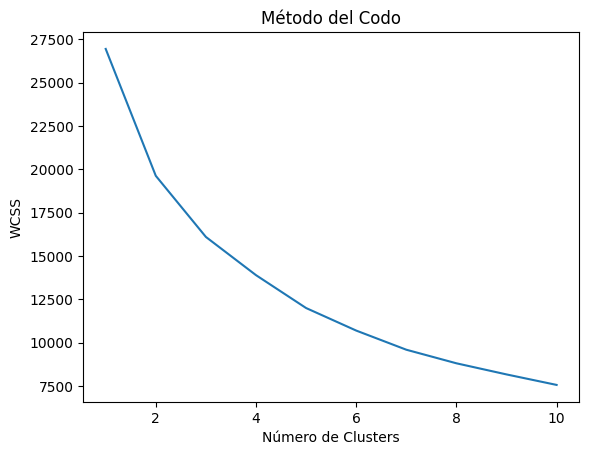

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrio']
data_for_clustering = data[features]

# Escalar los datos para que todas las características tengan la misma escala
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determinar el número óptimo de clusters utilizando el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=100, random_state=33)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualizar el método del codo para encontrar el número óptimo de clusters
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()


In [5]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=200, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Agregar la información de los clusters al DataFrame original
data['clusterKM'] = clusters

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

features_knn = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrio']

data_for_knn_train = data[features_knn]
target_column = 'precioUSD'
target = data[target_column]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_for_knn_train, target, train_size=0.99, random_state=33)

# Eliminar train_test_split y usar todo el conjunto de entrenamiento
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)

# Crear instancias de modelos con diferentes configuraciones
knns = dict()
r2_scores = []
for i in range(1, 25):
    knns[f'knn{i}'] = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m = knns[f'knn{i}']
    m.fit(X_train_scaled, y_train)
    
    scores_r2 = cross_val_score(m, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_scores.append((f'knn{i}', scores_r2.mean()))

# Ordenar modelos por R^2 descendente y obtener sus nombres
sorted_models = [model[0] for model in sorted(r2_scores, key=lambda x: x[1], reverse=True)]

# Asignar pesos más altos a los mejores modelos
weights = [3 if name in sorted_models[:3] else 2 if name in sorted_models[3:6] else 1 for name in knns.keys()]

# Eliminar los 10 peores modelos
selected_models = [(name, model) for name, model in knns.items() if name in sorted_models[:12]]
# Combina los modelos mediante votación con pesos

ensemble_model = VotingRegressor(estimators=selected_models, weights=weights[:12])
# Entrena el modelo ensamblado
ensemble_model.fit(X_train_scaled, y_train)

# Escalar todos los datos
X_testing = X_test.copy()
X_test_scaled = scaler_knn.transform(X_test)
all_data_predictions = ensemble_model.predict(X_test_scaled)
X_testing.loc[:, 'precioUSDPredicted'] = all_data_predictions

ensemble_r2 = r2_score(y_test, all_data_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, all_data_predictions))

# Imprimir resultados
print(f"R^2 en el conjunto de prueba para el modelo ensamblado: {ensemble_r2}")
print(f"RMSE del modelo ensamblado: {ensemble_rmse}")


R^2 en el conjunto de prueba para el modelo ensamblado: 0.9030424321183425
RMSE del modelo ensamblado: 25487.330482073197


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Crear instancias de PolynomialFeatures y LinearRegression
poly_features = PolynomialFeatures(degree=4)
poly_linear_model = make_pipeline(poly_features, LinearRegression())
poly_linear_model.fit(X_train_scaled, y_train)

random_forest_model = RandomForestRegressor(n_estimators=300, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gradient_boosting_model.fit(X_train_scaled, y_train)

# Hacer predicciones en el conjunto de prueba
poly_linear_predictions = poly_linear_model.predict(X_test_scaled)
random_forest_predictions = random_forest_model.predict(X_test_scaled)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test_scaled)

# Calcular RMSE y R^2 para cada modelo
poly_linear_rmse = np.sqrt(mean_squared_error(y_test, poly_linear_predictions))
random_forest_rmse = np.sqrt(mean_squared_error(y_test, random_forest_predictions))
gradient_boosting_rmse = np.sqrt(mean_squared_error(y_test, gradient_boosting_predictions))

poly_linear_r2 = r2_score(y_test, poly_linear_predictions)
random_forest_r2 = r2_score(y_test, random_forest_predictions)
gradient_boosting_r2 = r2_score(y_test, gradient_boosting_predictions)

print("\nPolynomial Linear Regression:")
print(f"RMSE: {poly_linear_rmse}")
print(f"R^2: {poly_linear_r2}")
print("\nRandom Forest:")
print(f"RMSE: {random_forest_rmse}")
print(f"R^2: {random_forest_r2}")
print("\nGradient Boosting:")
print(f"RMSE: {gradient_boosting_rmse}")
print(f"R^2: {gradient_boosting_r2}")


Polynomial Linear Regression:
RMSE: 38440.21948763781
R^2: 0.7794511843640265

Random Forest:
RMSE: 27587.774353324927
R^2: 0.8864031358814815

Gradient Boosting:
RMSE: 34510.490963693825
R^2: 0.8222394898090221


In [13]:
r2_scores

[('knn1', 0.6707458073381288),
 ('knn2', 0.7355984577810206),
 ('knn3', 0.757222773939674),
 ('knn4', 0.7666724092481202),
 ('knn5', 0.7715757467183602),
 ('knn6', 0.7768296116790602),
 ('knn7', 0.7780436199013687),
 ('knn8', 0.7803289070571118),
 ('knn9', 0.7795923019969059),
 ('knn10', 0.7777251059022775),
 ('knn11', 0.7770368068899377),
 ('knn12', 0.7760827821602818),
 ('knn13', 0.7754900399626843),
 ('knn14', 0.7744391025421374),
 ('knn15', 0.7735802411663518),
 ('knn16', 0.7726261388728706),
 ('knn17', 0.7720558265034644),
 ('knn18', 0.7715811820322663),
 ('knn19', 0.7707271056920265),
 ('knn20', 0.7696583312815038),
 ('knn21', 0.768625854235965),
 ('knn22', 0.7680432389137304),
 ('knn23', 0.7671802688217967),
 ('knn24', 0.7658185413132867)]

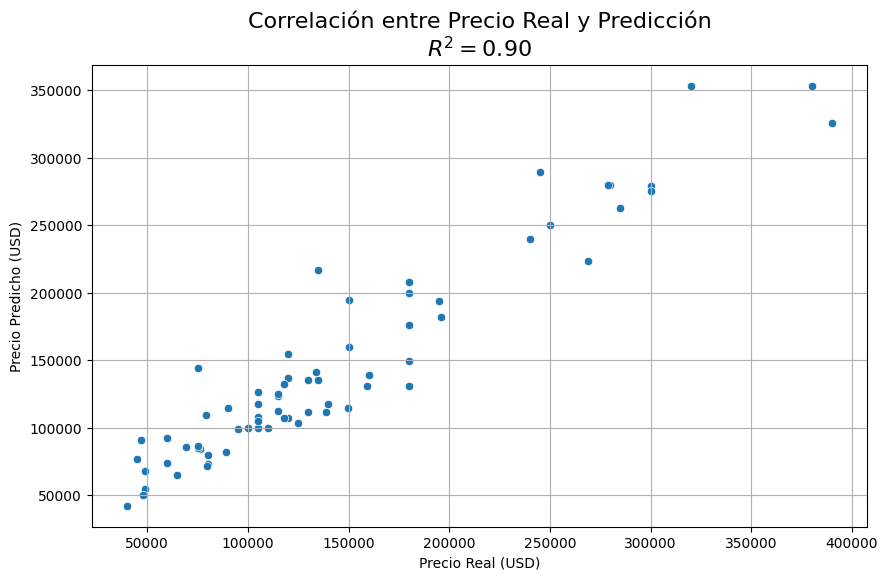

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# Calcula el R^2 para mostrarlo en el gráfico
ensemble_r2 = r2_score(y_test, all_data_predictions)

# Crea un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=all_data_predictions)
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2={ensemble_r2:.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)
plt.show()